## Import libraries

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# regex - cleaning
import re
# lematyzacja
import spacy
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer 
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# SVM
from sklearn.svm import SVC

# Read data

#### Data for training and testing

In [66]:
file_path_conc = r'C:\Users\Chill\Desktop\INZYNIERKA\dane\found_internet\CONCATENATED_DATA.xlsx'
df_original = pd.read_excel(file_path_conc)

In [67]:
df_original.head()

,Comment,Is_toxic,source
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0,dataset_poleval
1,Brawo ty Daria kibic ma być na dobre i złe,0,dataset_poleval
2,"Super, polski premier składa kwiaty na grobach...",0,dataset_poleval
3,Musi. Innej drogi nie mamy.,0,dataset_poleval
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0,dataset_poleval


#### Data to predict

In [68]:
# Load the CSV file with the correct encoding (UTF-8)
file_path_yt = r'C:\Users\Chill\Desktop\INZYNIERKA\dane\extracted_comments\comms_test.xlsx'
# comments from 4 videos:
# https://www.youtube.com/watch?v=t4O1LLk6qlY
# https://www.youtube.com/watch?v=r3qhl12iHKc
# https://www.youtube.com/watch?v=iLTLbe13hLg
# https://www.youtube.com/watch?v=v7CQkivQNQI

df_predict = pd.read_excel(file_path_yt)

In [69]:
df_predict.head()

,Comments
0,JKM jest zwolennikiem otwartej migracji ludzi ...
1,Korwin jest najlepszy
2,ten występ się dobrze starzeje jak popatrzymy ...
3,Wracam po protestach we Francji.
4,"Po 7 latach sie sprawdziło, gosc mysli lata do..."


## Preprocessing

In [70]:
df = df_original

In [71]:
df_original['source'].unique()

array(['dataset_poleval', 'dataset_zwroty', 'dataset_wykop'], dtype=object)

In [72]:
# Wybieram na razie tylko jeden dataset, najmniej skomplikowany
#df = df[df['source'] == 'dataset_poleval']
df.head()

,Comment,Is_toxic,source
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0,dataset_poleval
1,Brawo ty Daria kibic ma być na dobre i złe,0,dataset_poleval
2,"Super, polski premier składa kwiaty na grobach...",0,dataset_poleval
3,Musi. Innej drogi nie mamy.,0,dataset_poleval
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0,dataset_poleval


##### Cleaning

In [73]:
# re.sub() Replaces one or many matches with a string
# \w characters from a to Z, digits from 0-9, and the underscore _ character
# \s whitespace
# replace with empty string (delete) any character that is not: whitespace, a number, a character a-z or underscore
df['Clean_comment'] = df['Comment'].str.lower().apply(lambda row: re.sub(r'[^\w\s]', '', row))
df.head()

,Comment,Is_toxic,source,Clean_comment
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0,dataset_poleval,dla mnie faworytem do tytułu będzie cracovia z...
1,Brawo ty Daria kibic ma być na dobre i złe,0,dataset_poleval,brawo ty daria kibic ma być na dobre i złe
2,"Super, polski premier składa kwiaty na grobach...",0,dataset_poleval,super polski premier składa kwiaty na grobach ...
3,Musi. Innej drogi nie mamy.,0,dataset_poleval,musi innej drogi nie mamy
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0,dataset_poleval,odrzut natychmiastowy kwaśna mina mam problem


###### Lematyzacja

In [74]:
nlp = spacy.load('pl_core_news_sm')  # more precise - pl_core_news_lg / less precise & quick pl_core_news_sm

In [75]:
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

df['Final_comment'] = df['Clean_comment'].apply(lemmatize_text)

In [76]:
df.head(5)

,Comment,Is_toxic,source,Clean_comment,Final_comment
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0,dataset_poleval,dla mnie faworytem do tytułu będzie cracovia z...,dla ja faworyt do tytuł być cracovia zobaczyć ...
1,Brawo ty Daria kibic ma być na dobre i złe,0,dataset_poleval,brawo ty daria kibic ma być na dobre i złe,brawo ty Daria kibic mieć być na dobry i zły
2,"Super, polski premier składa kwiaty na grobach...",0,dataset_poleval,super polski premier składa kwiaty na grobach ...,super polski premier składać kwiat na groba ko...
3,Musi. Innej drogi nie mamy.,0,dataset_poleval,musi innej drogi nie mamy,musieć inny droga nie mieć
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0,dataset_poleval,odrzut natychmiastowy kwaśna mina mam problem,odrzut natychmiastowy kwaśna mina mieć problem


##### Stop words - Polish

In [77]:
with open(r'C:\Users\Chill\Desktop\INZYNIERKA\dane\polish_stopwords.txt', 'r', encoding='utf-8') as file:
    polish_stop_words = [row.strip() for row in file]

##### Tokenization & Vectorization

### Function - Vectorizer

In [78]:
def Vectorize(method = 'Bag of Words', stop_words = None):
    if method == 'Bag of Words':
        vectorizer = CountVectorizer(lowercase=True, stop_words=polish_stop_words) # TODO parametry
    elif method =='TF-IDF':
        vectorizer = TfidfVectorizer(lowercase=True, stop_words=polish_stop_words) # TODO parametry
    else:
        raise ValueError("Method not found")
    return vectorizer

### Function - make_predictions

In [79]:
def make_predictions(data, comments_col = 'Final_comment', target_col = 'Is_toxic', vectoraizer_name = 'Bag of Words', 
                     model_name = 'Logistic Regression', stop_words = None, test_size = 0.2, n_splits=5):
    
    vectorizer = Vectorize(method = vectoraizer_name, stop_words = stop_words)
    X = vectorizer.fit_transform(data[comments_col])
    # Split data to training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, data[target_col], test_size=test_size, random_state=42)
    
    # MODEL
    # Logistic regression
    if model_name == 'Logistic Regression':
        model = LogisticRegression()
    # SVM
    elif model_name == 'SVM':
        model = SVC()
    else:
        raise ValueError('Wrong model_name')
    
    # cross fold validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=n_splits)    
    
    # TRAIN MODEL
    model.fit(X_train, y_train)
    # PREDICT
    predictions = model.predict(X_test)
    
    return y_test, predictions, cv_scores

### Function - Visualize results

In [80]:
def visualize_results(y_test,predictions, cv_scores, model_name: str, vectorizer_name: str):
    cm = confusion_matrix(y_test, predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
    print(f"MODEL - {model_name.upper()}")
    print(f"VECTORIZER - {vectorizer_name.upper()}")
    print("Dokładność: {}%".format(np.round(accuracy_score(y_test, predictions)*100,2)))
    print(f"Średnia dokładność z walidacji krzyżowej: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")
    print("Raport klasyfikacji:\n", classification_report(y_test, predictions))
    cm_display.plot(cmap=plt.cm.Greens)
    plt.show()
    print("\n--------------------------------------------------------\n")

In [81]:
# BoW
logReg_pred = make_predictions(data = df,
                            comments_col = 'Final_comment',
                            target_col  = 'Is_toxic',
                            vectoraizer_name = 'Bag of Words',
                            model_name = 'Logistic Regression',
                            stop_words = polish_stop_words,
                            test_size = 0.2)

svm_pred = make_predictions(data = df,
                            comments_col = 'Final_comment',
                            target_col  = 'Is_toxic',
                            vectoraizer_name = 'Bag of Words',
                            model_name = 'SVM',
                            stop_words = polish_stop_words,
                            test_size = 0.2)

# TF-IDF
logReg_pred_idf = make_predictions(data = df,
                            comments_col = 'Final_comment',
                            target_col  = 'Is_toxic',
                            vectoraizer_name = 'TF-IDF',
                            model_name = 'Logistic Regression',
                            stop_words = polish_stop_words,
                            test_size = 0.2)

svm_pred_idf = make_predictions(data = df,
                            comments_col = 'Final_comment',
                            target_col  = 'Is_toxic',
                            vectoraizer_name = 'TF-IDF',
                            model_name = 'SVM',
                            stop_words = polish_stop_words,
                            test_size = 0.2)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

MODEL - LOGISITIC REGRESSION
VECTORIZER - BAG OF WORDS
Dokładność: 86.48%
Średnia dokładność z walidacji krzyżowej: 0.86 (+/- 0.01)
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      4475
           1       0.88      0.78      0.82      3097

    accuracy                           0.86      7572
   macro avg       0.87      0.85      0.86      7572
weighted avg       0.87      0.86      0.86      7572



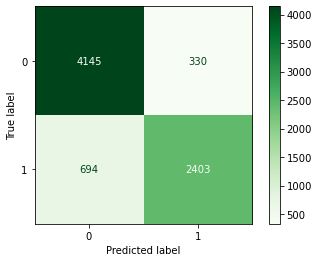


--------------------------------------------------------

MODEL - SVM
VECTORIZER - BAG OF WORDS
Dokładność: 83.37%
Średnia dokładność z walidacji krzyżowej: 0.82 (+/- 0.01)
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87      4475
           1       0.89      0.67      0.77      3097

    accuracy                           0.83      7572
   macro avg       0.85      0.81      0.82      7572
weighted avg       0.84      0.83      0.83      7572



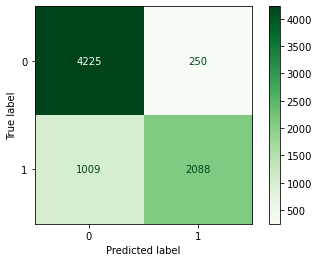


--------------------------------------------------------

MODEL - LOGISITIC REGRESSION
VECTORIZER - TF-IDF
Dokładność: 84.81%
Średnia dokładność z walidacji krzyżowej: 0.84 (+/- 0.01)
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88      4475
           1       0.90      0.71      0.79      3097

    accuracy                           0.85      7572
   macro avg       0.86      0.83      0.84      7572
weighted avg       0.85      0.85      0.84      7572



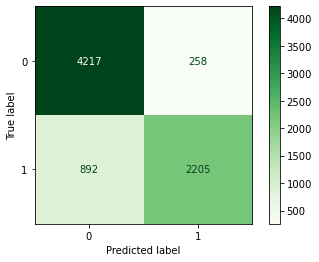


--------------------------------------------------------

MODEL - SVM
VECTORIZER - TF-IDF
Dokładność: 86.29%
Średnia dokładność z walidacji krzyżowej: 0.85 (+/- 0.01)
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.84      0.96      0.89      4475
           1       0.92      0.73      0.81      3097

    accuracy                           0.86      7572
   macro avg       0.88      0.84      0.85      7572
weighted avg       0.87      0.86      0.86      7572



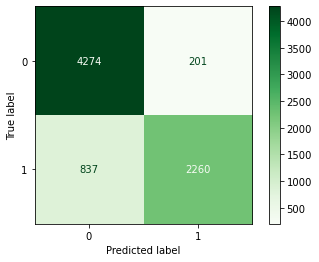


--------------------------------------------------------



In [82]:
visualize_results(y_test = logReg_pred[0],
                 predictions = logReg_pred[1],
                 cv_scores = logReg_pred[2],
                 model_name = 'Logisitic Regression',
                 vectorizer_name = 'Bag of Words')

visualize_results(y_test = svm_pred[0],
                 predictions = svm_pred[1],
                 cv_scores = svm_pred[2],
                 model_name = 'SVM',
                 vectorizer_name = 'Bag of Words')

visualize_results(y_test = logReg_pred_idf[0],
                 predictions = logReg_pred_idf[1],
                 cv_scores = logReg_pred_idf[2],
                 model_name = 'Logisitic Regression',
                 vectorizer_name = 'TF-IDF')

visualize_results(y_test = svm_pred_idf[0],
                 predictions = svm_pred_idf[1],
                 cv_scores = svm_pred_idf[2],
                 model_name = 'SVM',
                 vectorizer_name = 'TF-IDF')

In [83]:
df_added_pred = df.loc[list(logReg_pred[0].index)]

In [84]:
df_added_pred['prediction']=logReg_pred[1]

In [85]:
df_added_pred[df_added_pred['Is_toxic']!=df_added_pred['prediction']]

,Comment,Is_toxic,source,Clean_comment,Final_comment,prediction
7947,"Nie ucztowoć przy jednym stole z władzą, ty ni...",1,dataset_poleval,nie ucztowoć przy jednym stole z władzą ty nie...,nie ucztowoć przy jeden stół z władza ty nie d...,0
15509,popełnił najgorszą zbrodnię w tym kraju: skry...,0,dataset_wykop,popełnił najgorszą zbrodnię w tym kraju skryt...,popełnić najgorszą zbrodnia w ten kraj skryt...,1
14625,"\n\no właśnie, zapomniałem. To irytowało mnie ...",0,dataset_wykop,\n\no właśnie zapomniałem to irytowało mnie je...,\n\n o właśnie zapomnieć być to irytoweć ja je...,1
6456,"Śwaietowanie, radość i okrzyki \""raz sierpiem ...",0,dataset_poleval,śwaietowanie radość i okrzyki raz sierpiem raz...,śwaietowanąć radość i okrzyk raz sierpiem raz ...,1
28774,To niezła moda żeby siedzieć na serwisie z por...,1,dataset_wykop,to niezła moda żeby siedzieć na serwisie z por...,to niezła moda żeby siedzieć na serwis z porno...,0
...,...,...,...,...,...,...
33920,Bo nie ma podstawowych środków ochrony osobis...,1,dataset_wykop,bo nie ma podstawowych środków ochrony osobis...,bo nie mieć podstawowy środek ochrona osobis...,0
12865,Widok kamer monitoringu w tym miejscu bardzo m...,0,dataset_zwroty,widok kamer monitoringu w tym miejscu bardzo m...,widok kamera monitoring w ten miejsce bardzo j...,1
28196,Macie w tej chwili odblokować - a sukinsyny ...,1,dataset_wykop,macie w tej chwili odblokować a sukinsyny p...,mieć w ten chwila odblokować a sukinsyny ...,0
31487,"Wszyscy, którzy brali udział w akcji ratowania...",1,dataset_wykop,wszyscy którzy brali udział w akcji ratowania ...,wszystek który brać udział w akcja ratować zat...,0
